In [16]:
# importing required modules
from os.path import isfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.signal import savgol_filter

In [17]:
# setting up the correct paths
result_path = "../results/"
data_path = "../data/"

In [18]:
# decompress meta_data for plots
xztarfile = data_path+"meta_data.tar.xz"
tarfile = data_path+"meta_data.tar"
if isfile(xztarfile):
    !xz -d -v $xztarfile

if isfile(tarfile):
    !tar -xvf $tarfile -C ../data/

excel_sheet_ordered_degs_curvibacter_aep_to_wp.xlsx
raw_read_counts.csv
small_target_promotors.xlsx
target_promotors.xlsx


In [38]:
# overview
# 470 green
# 570 red
# J23100 == CPL_0017

In [35]:
'''generate_time_in_minutes_list

    This function takes a dataframe in ../data/ with the measurement timepoints in the first row.
    The measurement time has following format: int h int min. It then calculates the
    minutes of the measurement time as an integer value and appends this value into a
    list.
    
    :param dataframe
        :type pd.DataFrame
    
    :returns minute_time
        :type list[int]

'''

def generate_time_in_minutes_list(dataframe:pd.DataFrame)->list:
    counter = -1
    minute_time = []
    for i in list(dataframe.iloc[0,2:]):
        hours = int(i.split("h")[0])
        minutes = i.split("min")[0].split("h")[-1]
        
        if counter == 0 or counter == -1:
        
            if minutes != ' ':
                minutes = int(minutes)
            else:
                minutes = 0
                    
            time_in_minutes = minutes + (hours * 60)
        
            if int(time_in_minutes) == 0:
                counter += 1
            
            if counter == 0 or counter == -1:
                minute_time.append(time_in_minutes)
            
        else:
            break
            
    return minute_time

In [36]:
'''extract_content
    
    This function takes a dataframe in ../data/ with a Content column in which
    the 5'UTR identifier reside. In each row there should be values for one 5'UTR identifier
    named in the format: CPL_XXXX where XXXX is a number. The function returns a list of 
    all CPL identifier in the current dataframe.
    
    :param df
        :type pd.DataFrame
        
    :returns content_to_plot
        :type list[str]

'''
def extract_content(df:pd.DataFrame)->list:
    content_to_plot = []
    for cont in df.Content:
        if type(cont) == str:
            if cont.startswith("CPL"):
                
                content_to_plot.append(cont)
    return content_to_plot

In [37]:
'''extract_datasets
    
    This function takes a dataframe in ../data/ and return the OD, GFP and RFP values
    as pandas dataframes.
    
    :param df
        :type pd.DataFrame
    
    :returns [od_df,green_df,red_df]
        :type list[pd.DataFrame]

'''
def extract_datasets(df:pd.DataFrame)->list:

    od_columns = ["Well","Content"]
    green_columns = ["Well","Content"]
    red_columns = ["Well","Content"]

    for i in df.columns:
        if i.startswith('Blank corrected based on Raw Data (600'):
            od_columns.append(i)
        elif i.startswith(' Blank corrected based on Raw Data (470-15'):
            green_columns.append(i)
        elif i.startswith(' Blank corrected based on Raw Data (570-15'):
            red_columns.append(i)
            
    od_df = df[od_columns].dropna()
    green_df = df[green_columns].dropna()
    red_df = df[red_columns].dropna()    
    
    return [od_df,green_df,red_df]

In [22]:
'''plot_od_array

    This function takes the time in minutes list from the generate_time_in_minutes_list function, 
    an array of the values which should get visualized, a path as a string variable for saving the 
    figure and a header which serves as title for the figure.
    
    The function calculates the timepoint of the maximum slope of the data (point of highest growth rate).
    This is used for calculating the index of the exponential phase and the stationary phase, which are returned 
    by the function. Additionally it applies the savgol_filter to the data in arr. 
    
    :param header - Title for the figure (e.g., CPL_0025)
        :type str 
    :param time
        :type list[int]
    :param arr
        :type np.array
    :param save_path
        :type str
        
    :returns index_exponential_phase, index_stationary_phase
        :type tuple(int, int)

'''
def plot_od_array(header:str, time:list, arr:np.array, save_path:str):
    
    arr = savgol_filter(arr,window_length=19,polyorder=2)
    max_slope = [x - z for x, z in zip(list(arr[1:]), list(arr[:-1]))]
    
    for i,val in enumerate(max_slope):
        if val == max(max_slope[40:-40]):
            index = i
    
    for i,val in enumerate(arr):
        if val == max(arr):
            mindex = i
    
    index_exponential_phase = index
    index_stationary_phase = mindex
    
    max_val = arr[mindex] # str(round(max_val,2))
    
    mindex = time[mindex]
    index = time[index]
    
    vlabel = str(index) + " min."    
    vlabel2 = str(mindex) + " min."
    
    plt.figure(figsize=(12,8))
    plt.scatter(x=time,y=arr,color="blue", label="OD600 values")
    
    plt.vlines(index, 0, max(arr)+np.mean(arr), color="red", label="exponential phase")
    plt.vlines(mindex, 0, max(arr)+np.mean(arr), color="green", label="stationary phase")

    plt.ylim(0,max(arr)+0.25)
    plt.title(header)
    plt.grid()
    plt.xlabel("time in minutes", fontsize=15)
    plt.ylabel("OD600", fontsize=15)
    plt.tight_layout()
    plt.legend(fontsize=12)
    plt.savefig(save_path, dpi=300)
    plt.close()
    return index_exponential_phase, index_stationary_phase

'''plot_red_vs_green
    
    This function takes the time in minutes list from the generate_time_in_minutes_list function, 
    an array of the values which should get visualized, an index for the exponential and the stationary phase,
    a path as a string variable for saving the figure and a header which serves as title for the figure.
    
    The function then uses the interp1d function of the scipy.interpolate module to interpolate the data with 
    a linear and a cubic method. All datapoints including the uninterpolated data are then visualized in a single figure
    with vlines of the exponential and stationary phases.
    
    :param header
        :type str
    :param time
        :type list
    :param red_vs_green
        :type np.array
    :param index_exp
        :type int
    :param index_stat
        :type int
    :param save_path
        :type str
    
    :returns none
        :tpye none

'''
def plot_red_vs_green(header:str, time:list, red_vs_green:np.array,index_exp:int, index_stat:int, save_path:str):
    f = interpolate.interp1d(time,red_vs_green , kind = 'linear')
    f2 = interpolate.interp1d(time,red_vs_green , kind = 'cubic')
    
    plt.figure(figsize=(12,8))
    plt.plot(time, red_vs_green, 'o', time, f(time), '-', time, f2(time), '--')
    plt.vlines(time[index_exp],0,max(red_vs_green)+np.mean(red_vs_green),color="red", label="RFP/GFP in peak exp. phase")
    plt.vlines(time[index_stat],0,max(red_vs_green)+np.mean(red_vs_green),color="green", label="RFP/GFP in stat. phase")

    plt.title(header)
    plt.ylim(0.1,max(red_vs_green)+0.1)
    plt.grid()
    plt.xlabel("time in minutes", fontsize=15)
    plt.ylabel("RFP/GFP Fluorescence", fontsize=15)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

'''change_values
    
    This function is a helper function to change the "," signs to "." and it was used 
    to detect values that have been changed due to saving issues with Microsoft Excel. 
    
    :param header - column to parse
        :type str
    :param cont - CPL identifier in Content
        :type str
    :param df
        :type pd.DataFrame
    :param columns
        :type list[str]
    
    :returns arr
        :type np.array
'''
def change_values(header:str,cont:str,df:pd.DataFrame,columns:list)->np.array:
    arr = []
    for item in df[df[header] == cont].loc[:,columns].items():
        val = item[1].values[0]
        try:
            val = val.replace(",",".")
            val = float(val)
            arr.append(val)
        except Exception as e:
            if len(val) > 0:
                replacement = val[-1]
            else:
                replacement = 0.0
            print("[*] Date detected transform: {} to {}".format(val, replacement))
            val = replacement
            arr.append(val)
    return np.array(arr)

'''plot_bar

    Function for drawing and saving a bar plot with values in l and a x-tick description in content.
    
    :param l
        :type list
    :param content
        :type str
    :param savep
        :type str
    :param title
        :type str

'''
def plot_bar(l:list, content:str, savep:str, title:str):
    plt.figure(figsize=(12,8))
    plt.bar(x=range(len(l)), height=l, linewidth=2, edgecolor='black')
    plt.xticks(range(len(content)), content, rotation=60)
    plt.ylim(0,max(l)+np.mean(l))
    plt.title(title)
    plt.tight_layout()
    plt.savefig(savep)
    plt.close()

In [23]:
def outlier_smoother(x,time,content,index_exp, index_stat, savep, m=3, win=3, plots=False):
    ''' finds outliers in x, points > m*mdev(x) [mdev:median deviation] 
    and replaces them with the median of win points around them '''
    x_corr = np.copy(x)
    xtick_locs = np.arange(0,len(time),step=20)# range(len(time))
    xtick_labels = time[::20]
    d = np.abs(x - np.median(x))
    mdev = np.median(d)
    idxs_outliers = np.nonzero(d > m*mdev)[0]
    for i in idxs_outliers:
        if i-win < 0:
            x_corr[i] = np.median(np.append(x[0:i], x[i+1:i+win+1]))
        elif i+win+1 > len(x):
            x_corr[i] = np.median(np.append(x[i-win:i], x[i+1:len(x)]))
        else:
            x_corr[i] = np.median(np.append(x[i-win:i], x[i+1:i+win+1]))
    if plots:
        plt.figure('outlier_smoother '+content, clear=True)
        plt.plot(x, label='orig.', lw=5)
        plt.plot(idxs_outliers, x[idxs_outliers], 'ro', label='outliers')                                                                                                                    
        plt.plot(x_corr, '-o', label='corrected')
        
        # plt.vlines(time[index_exp],0,max(x),color="red")
        # plt.vlines(time[index_stat],0,max(x),color="green")
        
        plt.legend()
        plt.xticks(xtick_locs,xtick_labels)
        plt.xlabel("time in minutes")
        plt.tight_layout()
        plt.savefig(savep)
        plt.close()
    
    return x_corr

In [39]:
'''plot_phase_bar_plot

    This function can be used to reproduce result figure 4a of the manuscript. As input it takes a
    list of CPL identifiers, the normalized RFU values as described in equation 2 of the manuscript 
    for the stationary and for the exponential growth phases and some additional settings for 
    customizing the horizontal bar chart produced by this function.
    
    :param content - list of CPL identifer
        :type list[str]
    :param stat_phase - list of RFP/GFP values of the stationary phase
        :type list
    :param exp_phase - list of RFP/GFP values of the exponential phase
        :type list
    :param savep - filename and path for the figure
        :type str
    
    :returns none
        :type none
'''
def plot_phase_bar_plot(content:list,stat_phase:list,exp_phase:list,savep:str, xlim=1, legend_position="best", fsize=15, fsize_text=8, fig_size=(14,10)):

    try:
        if len(content) == len(stat_phase) == len(exp_phase):
            width = 0.4
            ind = np.arange(len(content))
            
            plt.figure(figsize=fig_size)
            bar1 = plt.barh(ind, exp_phase, width, label="RFP/GFP exponential phase", color="blue", edgecolor="black")
            bar2 = plt.barh(ind + width, stat_phase, width, label="RFP/GFP stationary phase", color="orange", edgecolor="black")
            
            for rect in bar1 + bar2:
                if rect.get_width() > 0:
                    if rect.get_width() > 0.0099999999:
                        if rect.get_width() > 0.1:
                            plt.text(rect.get_width() + 0.012, rect.get_y(), f'{np.abs(rect.get_width()):.2f}', ha='center', va='bottom', fontsize=fsize_text)
                        else:
                            plt.text(rect.get_width() + 0.015, rect.get_y(), f'{np.abs(rect.get_width()):.2f}', ha='center', va='bottom', fontsize=fsize_text)

                    else:
                        plt.text(rect.get_width() + 0.015, rect.get_y() - 0.05, f'{np.abs(rect.get_width()):.3f}', ha='center', va='bottom', fontsize=fsize_text)

            plt.xlabel("RFP/GFP fluorescence values", fontsize=fsize)
            plt.ylabel("Curvibacter Promoter Library (CPL) identifier", fontsize=fsize)
            # plt.title("Comparison of CPL-promoter constructs in exponentially and stationary growth phases")
            plt.yticks(ind + width / 2, content, fontsize=fsize-2)
            plt.xticks(fontsize=12)
            plt.legend(loc=legend_position, fontsize=fsize-2)
            plt.tight_layout()
            plt.xlim(0,xlim)
            plt.grid(axis="x")
            plt.savefig(savep)
            plt.close()
        else:
            raise Exception("[-] lists do not have the same length: content: {} stat_phase: {}  exp_phase: {}"
                            .format(len(content),len(stat_phase),len(exp_phase)))
    except Exception as e:
        raise Exception("[-] ERROR plotting phase bar plot with exception: {}".format(e))

In [40]:
'''plot_min_max_bar_plot
    
    This function is similar to the plot_phase_bar_plot except for plotting 
    the maximum and minimum values of the RFP/GFP values.
    
    :param content
        :type list[str]
    :param min_values
        :type list[float]
    :param max_values
        :type list[float]
    :param savep
        :type str
    
    :returns none
        :type none
'''
def plot_min_max_bar_plot(content:list,min_values:list,max_values:list,savep:str):

    try:
        if len(content) == len(min_values) == len(max_values):
            width = 0.4
            ind = np.arange(len(content))
            
            plt.figure(figsize=(14,10))
            bar1 = plt.barh(ind, min_values, width, label="RFP/GFP minimal values", color="blue", edgecolor="black")
            bar2 = plt.barh(ind + width, max_values, width, label="RFP/GFP maximal values", color="orange", edgecolor="black")
            
            for rect in bar1 + bar2:
                if rect.get_width() > 0:
                    if rect.get_width() > 0.0099999999:
                        plt.text(rect.get_width() + 0.015, rect.get_y() , f'{np.abs(rect.get_width()):.2f}', ha='center', va='bottom', fontsize=8)
                    else:
                        plt.text(rect.get_width() + 0.015, rect.get_y() , f'{np.abs(rect.get_width()):.3f}', ha='center', va='bottom', fontsize=8)

            plt.xlabel("RFP/GFP fluorescence values")
            plt.ylabel("Curvibacter Promoter Library (CPL) identifier")
            #plt.title("Comparison of CPL-promoter constructs in exponentially and stationary growth phases")
            plt.yticks(ind + width / 2, content)
            plt.legend(loc="best")
            plt.tight_layout()
            plt.xlim(0,1)
            plt.grid()
            plt.savefig(savep)
            plt.close()
        else:
            raise Exception("[-] lists do not have the same length: content: {} stat_phase: {}  exp_phase: {}"
                            .format(len(content),len(stat_phase),len(exp_phase)))
    except Exception as e:
        raise Exception("[-] ERROR plotting phase bar plot with exception: {}".format(e))

In [41]:
'''plot_content
    
    Wrapper function for plotting OD and RFU data. 
    This function combines the above described functions.

'''
def plot_content(df:pd.DataFrame, save_path:str):
   
    time = generate_time_in_minutes_list(df)
    datasets = extract_datasets(df)
    content = extract_content(df)
    
    min_val = []
    max_val = []
    
    exp_phase = []
    stat_phase = []
    
    real_cont = []
    for cont in content:
        od_arr = change_values("Content",cont,datasets[0], datasets[0].columns[2:])
        green_arr = change_values("Content",cont,datasets[1], datasets[1].columns[2:])
        red_arr = change_values("Content",cont,datasets[2], datasets[2].columns[2:])
                
        savep = save_path + cont + "_OD600.png"
        index_exp, index_stat = plot_od_array(cont, time, od_arr, savep)
        savep = save_path + cont + "_red_vs_green_sm.png"
        red_vs_green = np.array(red_arr.astype(float) / green_arr.astype(float))
        smoothed_red_vs_green = outlier_smoother(red_vs_green,time, cont, index_exp, index_stat, savep,plots=True)
        savep = save_path + cont + "_red_vs_green_sm_outlier_removed.png"
        plot_red_vs_green(cont,time, smoothed_red_vs_green,index_exp, index_stat, savep)
        
        min_val.append(min(smoothed_red_vs_green))
        max_val.append(max(smoothed_red_vs_green))
        exp_phase.append(red_vs_green[index_exp])
        stat_phase.append(red_vs_green[index_stat])
        real_cont.append(cont)
        
        od_color = "black"
        rfp_gfp_color = "darkorange"
        gfp_color = "green"
        rfp_color = "red"
        vline_color = "red"
        savep = save_path + "combined_od_red_vs_green_" + cont + ".png"
        plot_combined_od_red_vs_green_plot(df,cont,od_color,rfp_gfp_color,vline_color, savep)
        
    savep = save_path + "local_maxima.png"
    plot_bar(max_val, content, savep, "Local maxima of RFP/GFP")
    savep = save_path + "local_minima.png"
    plot_bar(min_val, content, savep, "Local minima of RFP/GFP")
    savep = save_path + "exponential_phase.png"
    plot_bar(exp_phase, content, savep, "Values of RFP/GFP in exponential phase")
    savep = save_path + "stationary_phase.png"
    plot_bar(stat_phase, content, savep, "Values of RFP/GFP in stationary phase")
    savep = save_path + "exponential_stationary_phase_bar_plots.png"
    plot_phase_bar_plot(content, stat_phase, exp_phase, savep)
    savep = save_path + "min_max_bar_plots.png"
    plot_min_max_bar_plot(content, min_values=min_val, max_values=max_val, savep=savep)
    dataframe = pd.DataFrame(zip(content, exp_phase, stat_phase, min_val, max_val),
                         columns=["CPL","EXP_PHASE","STAT_PHASE","MIN_VAL","MAX_VAL"])
    dataframe.to_csv(save_path+"comorehensive_dataframe.csv")
    return content, min_val, max_val, exp_phase, stat_phase
        

In [27]:
def collect_interesting_cpl_data(cpls_to_keep:list,content:list,exp_phase:list,stat_phase:list,all_cpls:dict)->dict:
    content = [cpl.replace("_","") for cpl in content]
    
    for idx,cpl in enumerate(content):
        if cpl in cpls_to_keep:
            if cpl in all_cpls.keys():
                all_cpls[cpl].append(exp_phase[idx])
                all_cpls[cpl].append(stat_phase[idx])
            else:
                all_cpls[cpl] = [exp_phase[idx], stat_phase[idx]]
    return all_cpls

In [28]:
def clean_collected_dictionary(all_cpls:dict)->list:
    content = []
    exp_phase = []
    stat_phase = []
    for key in all_cpls.keys():
        if key != "CPL0017":
            content.append(key)
            exp_phase.append(all_cpls[key][0])
            stat_phase.append(all_cpls[key][1])
            
        elif key == "CPL0017":
            content.append(key)
            exp_phase.append((all_cpls[key][0]+all_cpls[key][2])/2)
            stat_phase.append((all_cpls[key][1]+all_cpls[key][3])/2)
        else:
            print("ERROR")
    return [content,exp_phase,stat_phase]

# R2A Dataset

In [42]:
# restrict analysis to interesting CPLs
cpls = "0025,0022,0021,0017,0012,0008,0006,0005,0003,0002,0001,0017,0114,0112,0109,0106,0095,0083,0077,0075,0072,0071,0070,0069,0067,0065"
cpls = cpls.split(",")
cpls = ["CPL"+str(cpl) for cpl in cpls]

# this dictionary will inherit all informations from replicates 3 of cohort 1 and 2
all_cpls = {}

In [43]:
df1 = pd.read_csv(data_path + "r2aplus_30degree/csv/cohort1rep1_reconstituted.csv", delimiter="\t")
df2 = pd.read_csv(data_path + "r2aplus_30degree/csv/co1rep2.csv",skiprows=11, delimiter=";")
df3 = pd.read_csv(data_path + "r2aplus_30degree/csv/co1rep3.csv", skiprows=11, delimiter=";")

In [44]:
od_color = "black"
rfp_gfp_color = "darkorange"
gfp_color = "green"
rfp_color = "red"
vline_color = "red"

In [45]:
'''plot_combined_od_gfp

    This function plots a combination of the measured OD600 and GFP values to demonstrate

'''
def plot_combined_od_gfp(dataframe:pd.DataFrame,cpl_number:str,od_color:str,rfp_gfp_color:str,vline_color:str,savep:str)->int:
    
    time = generate_time_in_minutes_list(dataframe)
    
    datasets = extract_datasets(dataframe)
    content = extract_content(dataframe)
    
    od_arr = change_values("Content",cpl_number,datasets[0], datasets[0].columns[2:])
    green_arr = change_values("Content",cpl_number,datasets[1], datasets[1].columns[2:])
    red_arr = change_values("Content",cpl_number,datasets[2], datasets[2].columns[2:])
    od_data = savgol_filter(od_arr,window_length=19,polyorder=2)
    gfp_data = savgol_filter(green_arr,window_length=19,polyorder=2)

    max_slope = [x - z for x, z in zip(list(od_data[1:]), list(od_data[:-1]))]

    for i,val in enumerate(max_slope):
        if val == max(max_slope[40:-40]):
            index = i

    for i,val in enumerate(od_data):
        if val == max(od_data):
            mindex = i

    index_exponential_phase = index
    index_stationary_phase = mindex

    max_val = od_data[mindex]
    mindex = time[mindex]
    index = time[index]
    vlabel = str(index) + " min."    

    fig, ax = plt.subplots(figsize=(12,8))
    axes = [ax, ax.twinx()]

    colors = ('orange','blue')

    axes[0].plot(time,od_data,linestyle="none", marker='o', color=od_color)
    axes[0].set_ylabel("OD600", color=od_color, fontsize=15)
    axes[0].tick_params(axis='y', colors=od_color, labelsize=12)

    axes[1].plot(time,gfp_data,linestyle='none', marker='o', color=rfp_gfp_color)
    axes[1].set_ylabel("RFU GFP", color=rfp_gfp_color, fontsize=15)
    axes[1].tick_params(axis='y', colors=rfp_gfp_color, labelsize=12)
    axes[1].tick_params(axis='x', colors="black", labelsize=12)


    axes[0].set_xlabel("time in minutes", fontsize=15)
    ax.grid()

    ax.vlines(index, 0, max(od_data)+np.mean(od_data), linestyles="--", color=vline_color, label="exponential phase")
    ax.vlines(mindex, 0, max(od_data)+np.mean(od_data), linestyles="-", color=vline_color, label="stationary phase")

    ax.legend(loc="lower right", fontsize=15)

    plt.savefig(savep, dpi=400)
    plt.close()
    return 0

In [46]:
savep = "../results/cpl_0022_gfp_od600_correlation.png"
cpl_number = "CPL_0022"
plot_combined_od_gfp(df3, cpl_number, od_color, gfp_color, vline_color, savep)

0

In [131]:
savep = "../results/cpl_0017_gfp_od600_correlation.png"
cpl_number = "CPL_0017"
plot_combined_od_gfp(df3, cpl_number, od_color, gfp_color, vline_color, savep)

0

In [132]:
# combination of OD measurements and fluorescence measurements of RFP and GFP
def plot_combined_od_red_vs_green_plot(dataframe:pd.DataFrame,cpl_number:str,od_color:str,rfp_gfp_color:str,vline_color:str,savep:str)->int:
    time = generate_time_in_minutes_list(dataframe)
    datasets = extract_datasets(dataframe)
    content = extract_content(dataframe)

    od_arr = change_values("Content",cpl_number,datasets[0], datasets[0].columns[2:])
    green_arr = change_values("Content",cpl_number,datasets[1], datasets[1].columns[2:])
    red_arr = change_values("Content",cpl_number,datasets[2], datasets[2].columns[2:])
    red_vs_green = np.array(red_arr.astype(float) / green_arr.astype(float))
    od_data = savgol_filter(od_arr,window_length=19,polyorder=2)
    max_slope = [x - z for x, z in zip(list(od_data[1:]), list(od_data[:-1]))]

    for i,val in enumerate(max_slope):
        if val == max(max_slope[40:-40]):
            index = i

    for i,val in enumerate(od_data):
        if val == max(od_data):
            mindex = i

    index_exponential_phase = index
    index_stationary_phase = mindex

    max_val = od_data[mindex]
    
    index_exponential_phase = index
    index_stationary_phase = mindex
    
    mindex = time[mindex]
    index = time[index]
    vlabel = str(index) + " min."    



    red_vs_green = outlier_smoother(red_vs_green,time, cpl_number, index_exponential_phase, index_stationary_phase, savep,plots=False)

    fig, ax = plt.subplots(figsize=(12,8))

    axes = [ax, ax.twinx()]
    axes[0].plot(time,od_data,linestyle="none", marker='o', color=od_color)
    axes[0].set_ylabel("OD600", color=od_color, fontsize=17)
    axes[0].tick_params(axis='y', colors=od_color, labelsize=17)
    axes[0].tick_params(axis='x', colors="black", labelsize=17)

    axes[1].plot(time,red_vs_green,linestyle='-',marker="o", color=rfp_gfp_color)
    axes[1].set_ylabel("RFP/GFP", color=rfp_gfp_color, fontsize=17)
    axes[1].tick_params(axis='y', colors=rfp_gfp_color, labelsize=17)
    axes[1].tick_params(axis='x', colors="black", labelsize=17)

    axes[1].set_ylim(0,0.8)

    axes[0].set_xlabel("time in minutes", fontsize=15)
    axes[0].grid(axis="y",color="black", linestyle="--", alpha=0.5)
    axes[1].grid(axis="y",color=rfp_gfp_color,linestyle="--", alpha=0.5)
    
    ax.vlines(index, 0, max(od_data)+np.mean(od_data), linestyles="--", color=vline_color, label="exponential phase")
    ax.vlines(mindex, 0, max(od_data)+np.mean(od_data), linestyles="-", color=vline_color, label="stationary phase")

    ax.legend(loc="lower right", fontsize=15)

    plt.savefig(savep, dpi=400)
    plt.close()
    return 0

In [133]:
# subplots with CPL_0022 / CPL_0025 / CPL_0095 / CPL_0017

def get_data_for_subplot(dataframe:pd.DataFrame, cpl_number:str)->list:
    time = generate_time_in_minutes_list(dataframe)
    datasets = extract_datasets(dataframe)
    content = extract_content(dataframe)

    od_arr = change_values("Content",cpl_number,datasets[0], datasets[0].columns[2:])
    green_arr = change_values("Content",cpl_number,datasets[1], datasets[1].columns[2:])
    red_arr = change_values("Content",cpl_number,datasets[2], datasets[2].columns[2:])
    red_vs_green = np.array(red_arr.astype(float) / green_arr.astype(float))
    od_data = savgol_filter(od_arr,window_length=19,polyorder=2)
    max_slope = [x - z for x, z in zip(list(od_data[1:]), list(od_data[:-1]))]

    for i,val in enumerate(max_slope):
        if val == max(max_slope[40:-40]):
            index = i

    for i,val in enumerate(od_data):
        if val == max(od_data):
            mindex = i

    index_exponential_phase = index
    index_stationary_phase = mindex

    max_val = od_data[mindex]

    index_exponential_phase = index
    index_stationary_phase = mindex

    mindex = time[mindex]
    index = time[index]
    vlabel = str(index) + " min."    
    
    savep = "none"
    red_vs_green = outlier_smoother(red_vs_green,time, cpl_number, index_exponential_phase, index_stationary_phase, savep, plots=False)
    return [index, mindex, od_data, red_vs_green, time]

In [194]:
df_cpl_0095 = pd.read_csv(data_path + "r2aplus_30degree/csv/co2rep3.csv", skiprows=11, delimiter=";")
df_cpl_0095 = pd.read_csv(data_path + "r2aplus_30degree/csv/co2rep2.csv",skiprows=11, delimiter=";")


In [196]:
index_cpl_0022, mindex_cpl_0022, od_data_cpl_0022, red_vs_green_cpl_0022, time_cpl_0022 = get_data_for_subplot(df3, "CPL_0022")
index_cpl_0025, mindex_cpl_0025, od_data_cpl_0025, red_vs_green_cpl_0025, time_cpl_0025 = get_data_for_subplot(df3, "CPL_0025")
index_cpl_0017, mindex_cpl_0017, od_data_cpl_0017, red_vs_green_cpl_0017, time_cpl_0017 = get_data_for_subplot(df3, "CPL_0017")
index_cpl_0095, mindex_cpl_0095, od_data_cpl_0095, red_vs_green_cpl_0095, time_cpl_0095 = get_data_for_subplot(df_cpl_0095, "CPL_0095")
plot_list = [[index_cpl_0017, mindex_cpl_0017, od_data_cpl_0017, red_vs_green_cpl_0017, time_cpl_0017, "CPL0017"],
           [index_cpl_0025, mindex_cpl_0025, od_data_cpl_0025, red_vs_green_cpl_0025, time_cpl_0025, "CPL0025"],
           [index_cpl_0022, mindex_cpl_0022, od_data_cpl_0022, red_vs_green_cpl_0022, time_cpl_0022, "CPL0022"],
           [index_cpl_0095, mindex_cpl_0095, od_data_cpl_0095, red_vs_green_cpl_0095, time_cpl_0095, "CPL0095"]]

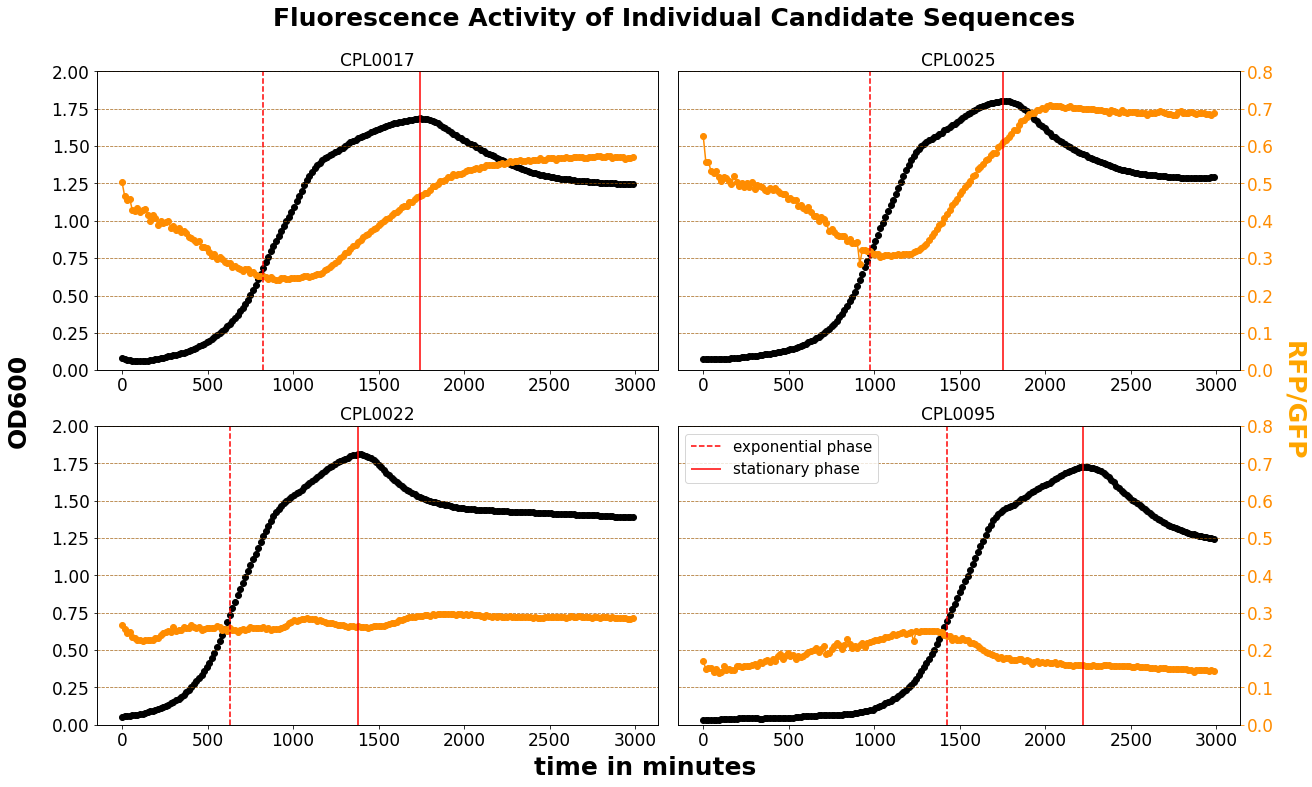

In [245]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(15,10), nrows=2, ncols=2)

axes = [ (ax1, ax1.twinx()), (ax2, ax2.twinx()), (ax3, ax3.twinx()), (ax4, ax4.twinx())]

for index, data in enumerate(plot_list):
    axes[index][0].plot(data[4],data[2],linestyle="none", marker='o', color=od_color)
    
    if index != 1 and index != 3:
        #axes[index][0].set_ylabel("OD600", color=od_color, fontsize=17)
        axes[index][0].tick_params(axis='y', colors=od_color, labelsize=17)
        axes[index][0].tick_params(axis='x', colors="black", labelsize=17)
    else:
        axes[index][0].tick_params(left = False, right = False , labelleft = False) 
        axes[index][0].tick_params(axis='x', colors="black", labelsize=17)
        
    axes[index][1].plot(data[4],data[3],linestyle='-',marker="o", color=rfp_gfp_color)
    
    if index != 0 and index != 2:
        #axes[index][1].set_ylabel("RFP/GFP", color=rfp_gfp_color, fontsize=17)
        axes[index][1].tick_params(axis='y', colors=rfp_gfp_color, labelsize=17)
        axes[index][1].tick_params(axis='x', colors="black", labelsize=17)
    else:
        axes[index][1].tick_params(left = False, right = False , labelleft = False, labelright=False) 
    
    axes[index][1].set_ylim(0,0.8)
    axes[index][0].set_ylim(0,2.0)
    
        
    axes[index][0].grid(axis="y",color="black", linestyle="--", alpha=0.5)
    axes[index][1].grid(axis="y",color=rfp_gfp_color,linestyle="--", alpha=0.5)

    axes[index][1].vlines(data[0], 0, max(data[2])+np.mean(data[2]), linestyles="--", color=vline_color, label="exponential phase")
    axes[index][1].vlines(data[1], 0, max(data[2])+np.mean(data[2]), linestyles="-", color=vline_color, label="stationary phase")
    
    if index == 3:
        axes[index][1].legend(loc="upper left", fontsize=15)
    
    axes[index][0].set_title(data[5], fontsize=17)
    
#fig.supxlabel('time in minutes', fontsize=20)
#fig.supylabel('OD600', fontsize=20, x=-0.02)
fig.text(x=-0.03, y=0.5, s="OD600", size=25, fontweight='bold', rotation=90, ha='center', va='center')
fig.text(x=0.55, y=-0.01, s="time in minutes", size=25, fontweight='bold', rotation=0, ha='center', va='center')

fig.text(x=1.15, y=0.5, s="RFP/GFP", size=25, fontweight='bold', rotation=-90, ha='center', va='center', color="orange")
fig.text(x=0.58, y= + 1.03, s="Fluorescence Activity of Individual Candidate Sequences ", size=25, fontweight='bold', rotation=0, ha='center', va='center')

#fig.suptitle("")
plt.tight_layout()
plt.subplots_adjust(right=1.1,)
plt.savefig("../results/subplots_cpls.png", dpi=400,  bbox_inches = 'tight')

In [229]:
size = fig.get_size_inches()

In [137]:
savep="../results/CPL_0022_combined_plot.png"
cpl_number = "CPL_0022"
red_vs_green = plot_combined_od_red_vs_green_plot(df3,"CPL_0022",od_color,rfp_gfp_color,vline_color, savep)

In [138]:
savep="../results/CPL_0025_combined_plot.png"
cpl_number = "CPL_0025"
red_vs_green = plot_combined_od_red_vs_green_plot(df3,"CPL_0025",od_color,rfp_gfp_color,vline_color, savep)

In [139]:
savep="../results/CPL_0017_combined_plot.png"
cpl_number = "CPL_0017"
plot_combined_od_red_vs_green_plot(df3,"CPL_0017",od_color,rfp_gfp_color,vline_color, savep)

0

In [140]:
save_path = result_path + "r2aplus_30degree_cohorte1/replicates1/"
content, min_val, max_val, exp_phase, stat_phase = plot_content(df1, save_path)

In [141]:
save_path = result_path + "r2aplus_30degree_cohorte1/replicates2/"
content, min_val, max_val, exp_phase, stat_phase = plot_content(df2, save_path)

In [142]:
save_path = result_path + "r2aplus_30degree_cohorte1/replicates3/"
content_cohorte1, min_val, max_val, exp_phase_cohorte1, stat_phase_cohorte1 = plot_content(df3, save_path)

all_cpls = collect_interesting_cpl_data(cpls,content_cohorte1,exp_phase_cohorte1,stat_phase_cohorte1,all_cpls)

In [143]:
df1 = pd.read_csv(data_path + "r2aplus_30degree/csv/co2rep1.csv",skiprows=11, delimiter=";")
df2 = pd.read_csv(data_path + "r2aplus_30degree/csv/co2rep2.csv",skiprows=11, delimiter=";")
df3 = pd.read_csv(data_path + "r2aplus_30degree/csv/co2rep3.csv", skiprows=11, delimiter=";")

In [144]:
savep="../results/CPL_0095_combined_plot.png"
cpl_number = "CPL_0095"
plot_combined_od_red_vs_green_plot(df3,cpl_number,od_color,rfp_gfp_color,vline_color, savep)

0

In [145]:
savep="../results/CPL_0109_combined_plot.png"
cpl_number = "CPL_0109"
plot_combined_od_red_vs_green_plot(df3,cpl_number,od_color,rfp_gfp_color,vline_color, savep)

0

In [146]:
save_path = result_path + "r2aplus_30degree_cohorte2/replicates1/"
content, min_val, max_val, exp_phase, stat_phase = plot_content(df1, save_path)

In [147]:
save_path = result_path + "r2aplus_30degree_cohorte2/replicates2/"
content, min_val, max_val, exp_phase, stat_phase = plot_content(df2, save_path)

In [148]:
save_path = result_path + "r2aplus_30degree_cohorte2/replicates3/"
content_cohorte2, min_val, max_val, exp_phase_cohorte2, stat_phase_cohorte2 = plot_content(df3, save_path)
all_cpls = collect_interesting_cpl_data(cpls,content_cohorte2,exp_phase_cohorte2,stat_phase_cohorte2,all_cpls)

In [149]:
# exp - stat phase
all_cpls

{'CPL0001': [0.014993989750943714, 0.03700828503740982],
 'CPL0002': [0.04358331374239219, 0.050126004347630926],
 'CPL0003': [0.06111773275062905, 0.0741537251319529],
 'CPL0005': [0.020746633275635595, 0.038130389131057305],
 'CPL0006': [0.03660289996344584, 0.04327906659557848],
 'CPL0008': [0.01623342175066313, 0.025700976174227813],
 'CPL0012': [0.018759342301943198, 0.031222360320258984],
 'CPL0017': [0.2511283663821686,
  0.46612831461718784,
  0.26897166428290115,
  0.49344045230416805],
 'CPL0021': [0.0038433503412630046, 0.004709818556170377],
 'CPL0022': [0.2588437548213617, 0.26379111917588666],
 'CPL0025': [0.3191238117730413, 0.6105869883806134],
 'CPL0065': [0.04272767462422635, 0.04388756298064174],
 'CPL0067': [0.0018249285236328244, 0.0035868547437097895],
 'CPL0069': [0.001067995728017088, 0.005020774181730377],
 'CPL0070': [0.013208329016885942, 0.015047563646318094],
 'CPL0071': [0.013042842970630531, 0.011467719115347382],
 'CPL0072': [0.003384414513468939, 0.0057

In [150]:
data_to_plot = clean_collected_dictionary(all_cpls)

In [151]:
# 0 = content | 1 = exp | 2 = stat
data_to_plot

[['CPL0001',
  'CPL0002',
  'CPL0003',
  'CPL0005',
  'CPL0006',
  'CPL0008',
  'CPL0012',
  'CPL0017',
  'CPL0021',
  'CPL0022',
  'CPL0025',
  'CPL0065',
  'CPL0067',
  'CPL0069',
  'CPL0070',
  'CPL0071',
  'CPL0072',
  'CPL0075',
  'CPL0077',
  'CPL0083',
  'CPL0095',
  'CPL0106',
  'CPL0109',
  'CPL0112',
  'CPL0114'],
 [0.014993989750943714,
  0.04358331374239219,
  0.06111773275062905,
  0.020746633275635595,
  0.03660289996344584,
  0.01623342175066313,
  0.018759342301943198,
  0.2600500153325349,
  0.0038433503412630046,
  0.2588437548213617,
  0.3191238117730413,
  0.04272767462422635,
  0.0018249285236328244,
  0.001067995728017088,
  0.013208329016885942,
  0.013042842970630531,
  0.003384414513468939,
  0.002546713594872235,
  0.028497458283727347,
  0.0074455123866251525,
  0.27901373795366,
  0.05543447360940017,
  0.15116097865045972,
  0.015414357520299007,
  0.003720947626259793],
 [0.03700828503740982,
  0.050126004347630926,
  0.0741537251319529,
  0.03813038913105

In [152]:
save_path = "../results/"
savep = save_path + "exponential_phase_replicates3_unsorted.png"
plot_phase_bar_plot(data_to_plot[0], data_to_plot[2], data_to_plot[1], savep, xlim=0.8)

In [153]:
sorted_stat_phase = []
sorted_exp_phase = []
sorted_cont = []
max_promoter_strength = []
# 0 = content | 1 = exp | 2 = stat
for exp, stat, cont in sorted(zip(data_to_plot[1],data_to_plot[2],data_to_plot[0])):
    max_promoter_strength.append(max([exp,stat]))
    sorted_stat_phase.append(stat)
    sorted_exp_phase.append(exp)
    sorted_cont.append(cont)

In [154]:
sorted_exp_phase

[0.001067995728017088,
 0.0018249285236328244,
 0.002546713594872235,
 0.003384414513468939,
 0.003720947626259793,
 0.0038433503412630046,
 0.0074455123866251525,
 0.013042842970630531,
 0.013208329016885942,
 0.014993989750943714,
 0.015414357520299007,
 0.01623342175066313,
 0.018759342301943198,
 0.020746633275635595,
 0.028497458283727347,
 0.03660289996344584,
 0.04272767462422635,
 0.04358331374239219,
 0.05543447360940017,
 0.06111773275062905,
 0.15116097865045972,
 0.2588437548213617,
 0.2600500153325349,
 0.27901373795366,
 0.3191238117730413]

In [155]:
sorted_stat_phase

[0.005020774181730377,
 0.0035868547437097895,
 0.004522448017112876,
 0.0057871619658084175,
 0.003985158719252439,
 0.004709818556170377,
 0.005840363400389357,
 0.011467719115347382,
 0.015047563646318094,
 0.03700828503740982,
 0.06340501571261323,
 0.025700976174227813,
 0.031222360320258984,
 0.038130389131057305,
 0.03335850397548083,
 0.04327906659557848,
 0.04388756298064174,
 0.050126004347630926,
 0.08471219855659215,
 0.0741537251319529,
 0.0991271063809924,
 0.26379111917588666,
 0.479784383460678,
 0.17693355532011504,
 0.6105869883806134]

In [156]:
sorted_cont

['CPL0069',
 'CPL0067',
 'CPL0075',
 'CPL0072',
 'CPL0114',
 'CPL0021',
 'CPL0083',
 'CPL0071',
 'CPL0070',
 'CPL0001',
 'CPL0112',
 'CPL0008',
 'CPL0012',
 'CPL0005',
 'CPL0077',
 'CPL0006',
 'CPL0065',
 'CPL0002',
 'CPL0106',
 'CPL0003',
 'CPL0109',
 'CPL0022',
 'CPL0017',
 'CPL0095',
 'CPL0025']

In [157]:
def plot_phase_bar_plot(content:list,stat_phase:list,exp_phase:list,savep:str, xlim=1, legend_position="best", fsize=15, fsize_text=8, fig_size=(14,10)):

    try:
        if len(content) == len(stat_phase) == len(exp_phase):
            width = 0.4
            ind = np.arange(len(content))
            
            plt.figure(figsize=fig_size)
            bar1 = plt.barh(ind, exp_phase, width, label="RFP/GFP exponential phase", color="blue", edgecolor="black")
            bar2 = plt.barh(ind + width, stat_phase, width, label="RFP/GFP stationary phase", color="orange", edgecolor="black")
            
            for rect in bar1 + bar2:
                if rect.get_width() > 0:
                    if rect.get_width() > 0.0099999999:
                        if rect.get_width() > 0.1:
                            plt.text(rect.get_width() + 0.012, rect.get_y(), f'{np.abs(rect.get_width()):.2f}', ha='center', va='bottom', fontsize=fsize_text)
                        else:
                            plt.text(rect.get_width() + 0.015, rect.get_y(), f'{np.abs(rect.get_width()):.2f}', ha='center', va='bottom', fontsize=fsize_text)

                    else:
                        plt.text(rect.get_width() + 0.015, rect.get_y() - 0.05, f'{np.abs(rect.get_width()):.3f}', ha='center', va='bottom', fontsize=fsize_text)

            plt.xlabel("RFP/GFP fluorescence values", fontsize=fsize)
            plt.ylabel("Curvibacter Promoter Library (CPL) identifier", fontsize=fsize)
            # plt.title("Comparison of CPL-promoter constructs in exponentially and stationary growth phases")
            plt.yticks(ind + width / 2, content, fontsize=fsize-2 )
            plt.xticks(fontsize=20)
            plt.legend(loc=legend_position, fontsize=fsize-2)
            plt.xlim(0,xlim)
            plt.grid(axis="x")
            
            ax = plt.gca()

            # Set the y-tick labels
            ytick_labels = ax.get_yticklabels()
            
            promoters = ["CPL0025","CPL0095","CPL0022","CPL0017"]

            # Set the color for the specified indices
            for label in ytick_labels:
                if label.get_text() in promoters:
                    label.set_color('red')
                    
            
            plt.tight_layout()
            plt.savefig(savep)
            return label
        else:
            raise Exception("[-] lists do not have the same length: content: {} stat_phase: {}  exp_phase: {}"
                            .format(len(content),len(stat_phase),len(exp_phase)))
    except Exception as e:
        raise Exception("[-] ERROR plotting phase bar plot with exception: {}".format(e))

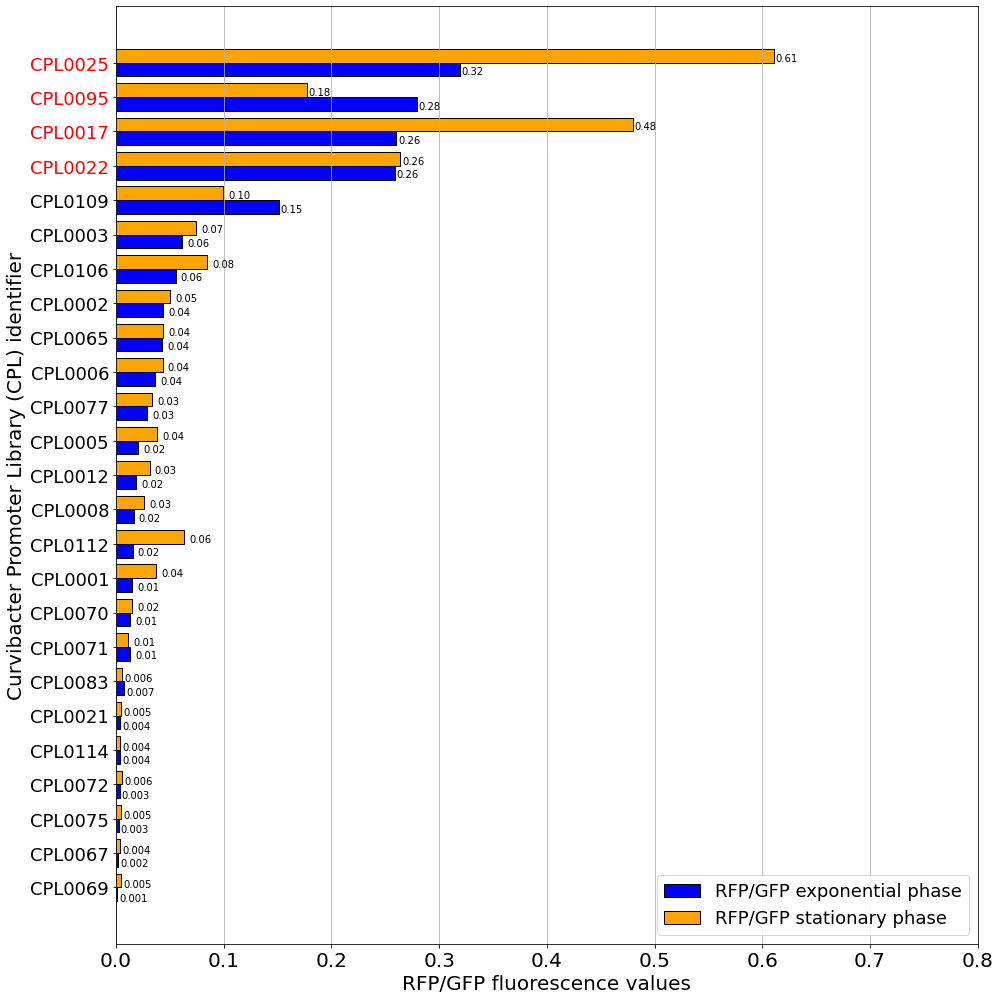

In [158]:
save_path = "../results/"
savep = save_path + "exponential_phase_replicates3_sorted.png"
label = plot_phase_bar_plot(sorted_cont,sorted_stat_phase, sorted_exp_phase, savep, xlim=0.8, legend_position="lower right", fsize=20, fsize_text=10, fig_size=(14,14))

In [159]:
promoter_strength = np.array(sorted_exp_phase) / np.array(sorted_stat_phase)
promoter_strength_sorted = []
sorted_cont_sorted = []
max_promoter_strength_sorted = []
for val, cont, maxprotstr in sorted(zip(promoter_strength, sorted_cont, max_promoter_strength)):
    max_promoter_strength_sorted.append(maxprotstr)
    promoter_strength_sorted.append(val)
    sorted_cont_sorted.append(cont)

In [160]:
sorted_exp_phase

[0.001067995728017088,
 0.0018249285236328244,
 0.002546713594872235,
 0.003384414513468939,
 0.003720947626259793,
 0.0038433503412630046,
 0.0074455123866251525,
 0.013042842970630531,
 0.013208329016885942,
 0.014993989750943714,
 0.015414357520299007,
 0.01623342175066313,
 0.018759342301943198,
 0.020746633275635595,
 0.028497458283727347,
 0.03660289996344584,
 0.04272767462422635,
 0.04358331374239219,
 0.05543447360940017,
 0.06111773275062905,
 0.15116097865045972,
 0.2588437548213617,
 0.2600500153325349,
 0.27901373795366,
 0.3191238117730413]

In [161]:
sorted_stat_phase

[0.005020774181730377,
 0.0035868547437097895,
 0.004522448017112876,
 0.0057871619658084175,
 0.003985158719252439,
 0.004709818556170377,
 0.005840363400389357,
 0.011467719115347382,
 0.015047563646318094,
 0.03700828503740982,
 0.06340501571261323,
 0.025700976174227813,
 0.031222360320258984,
 0.038130389131057305,
 0.03335850397548083,
 0.04327906659557848,
 0.04388756298064174,
 0.050126004347630926,
 0.08471219855659215,
 0.0741537251319529,
 0.0991271063809924,
 0.26379111917588666,
 0.479784383460678,
 0.17693355532011504,
 0.6105869883806134]

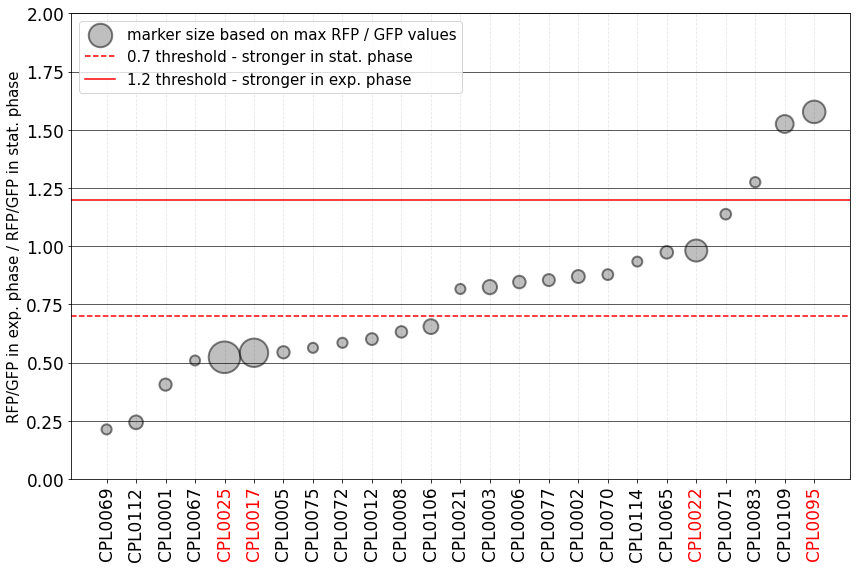

In [162]:
plt.figure(figsize=(12,8))

msize = np.interp(max_promoter_strength_sorted,  [min(max_promoter_strength_sorted), max(max_promoter_strength_sorted)], [100,1000])

xticks = []
for tick in range(len(sorted_cont_sorted)):
    xticks.append(tick)

plt.scatter(y=promoter_strength_sorted,x=xticks,s=msize, c="grey", edgecolor="black", lw=2, alpha=0.5, label="marker size based on max RFP / GFP values")
plt.axhline(0.7, color="red", linestyle="--", label="0.7 threshold - stronger in stat. phase")
plt.axhline(1.2, color="red", linestyle="-", label="1.2 threshold - stronger in exp. phase")



    
plt.xticks(xticks, sorted_cont_sorted, rotation= 90, fontsize=17)
plt.yticks(fontsize=17)
#for x,y,text in zip(xticks, promoter_strength_sorted, promoter_strength_sorted):
#    plt.text(x, y, str(round(text,2)), fontsize=12)


ax = plt.gca()

# Set the y-tick labels
xtick_labels = ax.get_xticklabels()

promoters = ["CPL0025","CPL0095","CPL0022","CPL0017"]

# Set the color for the specified indices
for label in xtick_labels:
    if label.get_text() in promoters:
        label.set_color('red')


plt.ylim(0.0,2.0)
plt.legend(fontsize=15, loc="upper left")
plt.grid(axis="y", color="black", alpha=0.8)
plt.grid(axis="x", color="black",alpha=0.1, linestyle="--")
plt.ylabel("RFP/GFP in exp. phase / RFP/GFP in stat. phase", fontsize=15)
plt.tight_layout()
plt.savefig("../results/promoter_strength.png", dpi=400)

In [163]:
promoter_strength_sorted

[0.21271534814358256,
 0.24310943459371484,
 0.4051522445794784,
 0.5087823884792583,
 0.5226508553996787,
 0.5420143387260707,
 0.5440970771194519,
 0.5631272234054452,
 0.5848142031387167,
 0.6008303699503136,
 0.6316266604278452,
 0.6543859627532517,
 0.8160293852993117,
 0.8242031353363983,
 0.8457414367431229,
 0.85427866623376,
 0.8694751219374228,
 0.8777719322102894,
 0.9337012371135351,
 0.9735713656069944,
 0.9812451443779415,
 1.137352845796087,
 1.27483717642104,
 1.5249207221834613,
 1.576940775585827]

# BMM9 Dataset

In [188]:
def plot_corrected_bmm9_content(df1:pd.DataFrame, df2:pd.DataFrame, save_path:str):
   
    time1 = generate_time_in_minutes_list(df1)
    datasets1 = extract_datasets(df1)
    content1 = extract_content(df1)
    time2 = generate_time_in_minutes_list(df2)
    datasets2 = extract_datasets(df2)
    content2 = extract_content(df2)
    
    od_data = datasets1[0].merge(datasets2[0], on="Content")
    green_data = datasets1[1].merge(datasets2[1], on="Content")
    red_data = datasets1[2].merge(datasets2[2], on="Content")
    od_data = od_data.drop('Well_y', axis=1)
    green_data = green_data.drop('Well_y', axis=1)
    red_data = red_data.drop('Well_y', axis=1)

    time = time1
    for t in time2:
        current_val = time[-1]
        current_val += 15
        time.append(current_val)
    content = content1
    
    min_val = []
    max_val = []
    exp_phase = []
    stat_phase = []
    
    for cont in content:
        od_arr = change_values("Content",cont,od_data, od_data.columns[2:])
        green_arr = change_values("Content",cont,green_data, green_data.columns[2:])
        red_arr = change_values("Content",cont,red_data, red_data.columns[2:])
                
        savep = save_path + cont + "_OD600.png"
        index_exp, index_stat = plot_od_array(cont, time, od_arr, savep)
        savep = save_path + cont + "_red_vs_green_sm.png"
        red_vs_green = np.array(red_arr.astype(float) / green_arr.astype(float))
        smoothed_red_vs_green = outlier_smoother(red_vs_green,time, cont, index_exp, index_stat, savep,plots=True)
        savep = save_path + cont + "_red_vs_green_sm_outlier_removed.png"
        plot_red_vs_green(cont, time, smoothed_red_vs_green,index_exp, index_stat, savep)
        
        min_val.append(min(smoothed_red_vs_green))
        max_val.append(max(smoothed_red_vs_green))
        exp_phase.append(red_vs_green[index_exp])
        stat_phase.append(red_vs_green[index_stat])
        
    savep = save_path + "local_maxima.png"
    plot_bar(max_val, content, savep, "Local maxima of RFP/GFP")
    savep = save_path + "local_minima.png"
    plot_bar(min_val, content, savep, "Local minima of RFP/GFP")
    savep = save_path + "exponential_phase.png"
    plot_bar(exp_phase, content, savep, "Values of RFP/GFP in exponential phase")
    savep = save_path + "stationary_phase.png"
    plot_bar(stat_phase, content, savep, "Values of RFP/GFP in stationary phase")
    savep = save_path + "exponential_stationary_phase_bar_plots.png"
    plot_phase_bar_plot(content, stat_phase, exp_phase, savep)
    savep = save_path + "min_max_bar_plots.png"
    plot_min_max_bar_plot(content, min_values=min_val, max_values=max_val, savep=savep)
    dataframe = pd.DataFrame(zip(content, exp_phase, stat_phase, min_val, max_val),
                         columns=["CPL","EXP_PHASE","STAT_PHASE","MIN_VAL","MAX_VAL"])
    dataframe.to_csv(save_path+"comorehensive_dataframe.csv")
    return content, min_val, max_val, exp_phase, stat_phase

In [189]:
df1 = pd.read_csv(data_path + "bmm9_30degree/csv/co1rep1.csv", skiprows=11, delimiter=";")
df2 = pd.read_csv(data_path + "bmm9_30degree/csv/co1rep1p2.csv",skiprows=11, delimiter=";")

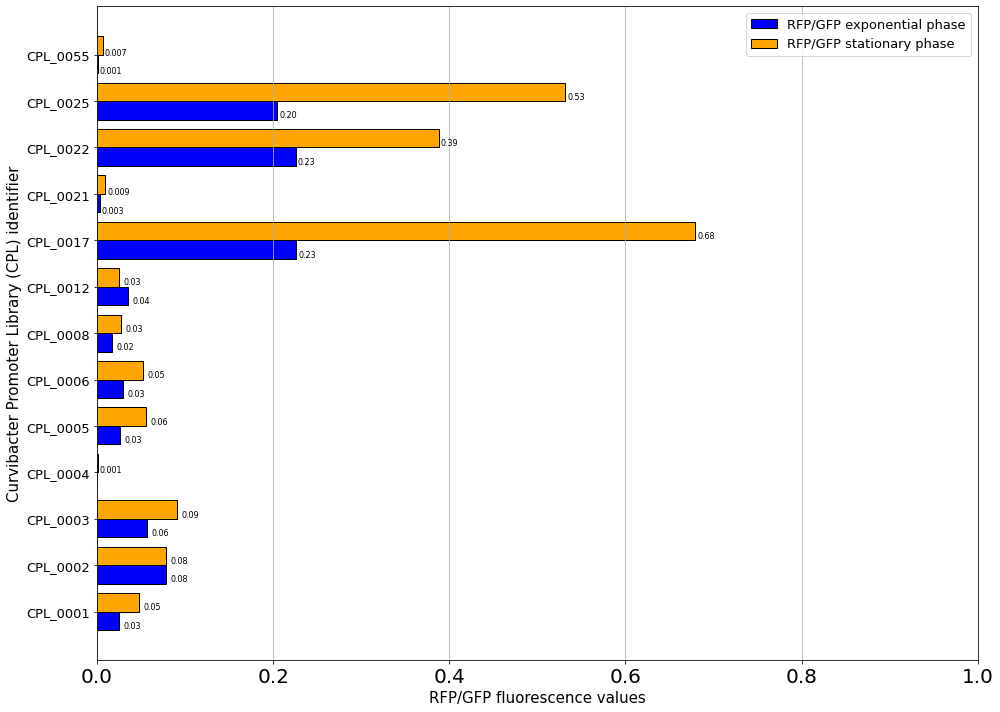

In [190]:
save_path = result_path + "bmm9_30degree_cohorte1/replicates1/"
content, min_val, max_val, exp_phase, stat_phase = plot_corrected_bmm9_content(df1, df2, save_path)

In [191]:
df1 = pd.read_csv(data_path + "bmm9_30degree/csv/co2rep1.csv", skiprows=10, delimiter=";")

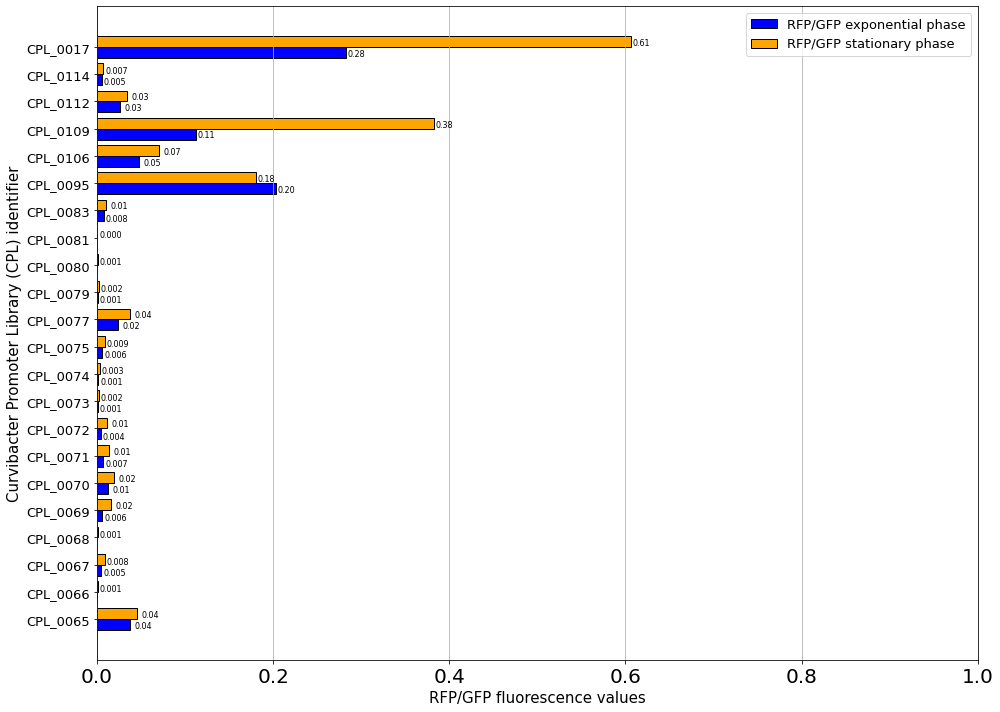

In [192]:
save_path = result_path + "bmm9_30degree_cohorte2/replicates1/"
content, min_val, max_val, exp_phase, stat_phase = plot_content(df1, save_path)

# calculating turning points

- this is already implemented in the functions above, the savgol_filter does the trick

In [151]:
df1 = pd.read_csv(data_path + "r2aplus_30degree/csv/cohort1rep1_reconstituted.csv", delimiter="\t")
df2 = pd.read_csv(data_path + "r2aplus_30degree/csv/co1rep2.csv",skiprows=11, delimiter=";")
df3 = pd.read_csv(data_path + "r2aplus_30degree/csv/co1rep3.csv", skiprows=11, delimiter=";")

In [152]:
# list of dataframes [od, green, red]
dataframes_df2 = extract_datasets(df2)
cpl0025_od = list(dataframes_df2[0].iloc[20][2:].apply(lambda x: float(x.replace(",","."))))

In [153]:
cpl0012_od = list(dataframes_df2[0].iloc[11][2:].apply(lambda x: float(x.replace(",","."))))

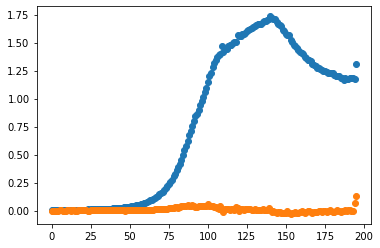

In [154]:
plt.scatter(x=range(len(cpl0025_od)),y=cpl0025_od)
plt.scatter(x=range(len(cpl0025_od)),y=np.gradient(cpl0025_od))

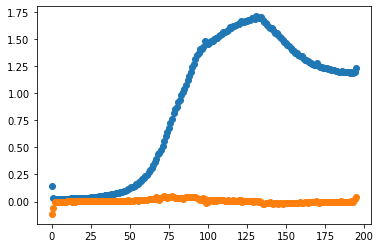

In [155]:
plt.scatter(x=range(len(cpl0012_od)),y=cpl0012_od)
plt.scatter(x=range(len(cpl0012_od)),y=np.gradient(cpl0012_od))

77 0.05589999999999995 0.05589999999999995


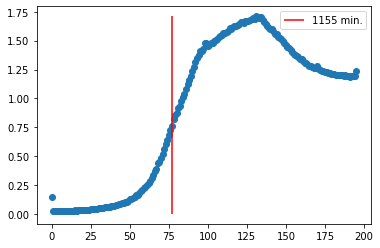

In [156]:
# omit first 20 datapoints and last 20 datapoints
# cpl0012_od = cpl0012_od[20:len(cpl0012_od)-20]
max_slope = [x - z for x, z in zip(cpl0012_od[1:], cpl0012_od[:-1])]

for index,val in enumerate(max_slope):
    if val == max(max_slope[20:-20]):
        print(index, val, max_slope[index])
        break

vlabel = str(index*15) + " min."
plt.scatter(x=range(len(cpl0012_od)),y=cpl0012_od)
plt.vlines(index, 0, max(cpl0012_od), color="red", label=vlabel)
plt.legend()

108 0.06719999999999993 0.06719999999999993


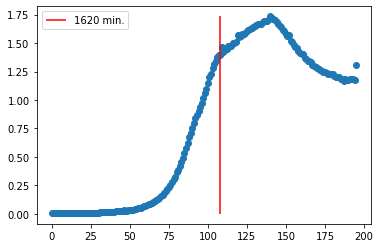

In [157]:
max_slope = [x - z for x, z in zip(cpl0025_od[1:], cpl0025_od[:-1])]

for index,val in enumerate(max_slope):
    if val == max(max_slope[20:-20]):
        print(index, val, max_slope[index])
        break

vlabel = str(index*15) + " min."
plt.scatter(x=range(len(cpl0025_od)),y=cpl0025_od)
plt.vlines(index, 0, max(cpl0025_od), color="red", label=vlabel)
plt.legend()

In [158]:
cpl0025_od = savgol_filter(cpl0025_od,window_length=19,polyorder=2)

100 0.04405846970367144 0.04405846970367144


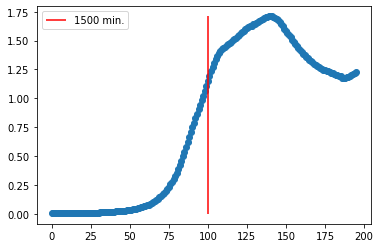

In [159]:
max_slope = [x - z for x, z in zip(cpl0025_od[1:], cpl0025_od[:-1])]

for index,val in enumerate(max_slope):
    if val == max(max_slope):
        print(index, val, max_slope[index])
        break

vlabel = str(index*15) + " min."
plt.scatter(x=range(len(cpl0025_od)),y=cpl0025_od)
plt.vlines(index, 0, max(cpl0025_od), color="red", label=vlabel)
plt.legend()

# plot raw read counts vs CPL

In [166]:
raw_counts = "../results/readCountsNormalizedWpToAEP.csv"
raw_counts_df = pd.read_csv(raw_counts)

In [167]:
raw_counts_df.head()

,Unnamed: 0,Wp_Number,aep,readCountMeanGSamples,readCountMeanNormalized,log2FoldChange,seq
0,0,WP_087493500.1,AEP_00006,697.000000,0.004744,0.594249,GGTCAGGCAATGCACGCTTCTTGCGTGCAGTTGCGCAGGCCAAAAC...
1,1,WP_087493505.1,AEP_00011,837.000000,0.005697,-0.973455,GCATCTGCATTACCCGGCATGCATGCGCGGGCGATATTGAGGTGCC...
2,2,WP_087493510.1,AEP_00016,1812.666667,0.012338,-1.014490,ACAGATTTACGTCAATTAGTGCTCTAGCGCACATCCAGTGTGCGCG...
3,3,WP_087493511.1,AEP_00017,13190.333333,0.089778,-0.294320,TGAAGTTTTTCCTGTGTGTGCTTCGGCTGGCTCAACACACAGGGAT...
4,4,WP_087493512.1,AEP_00018,974.666667,0.006634,-0.985040,GCAGTTGCAGGCACACCAAAAGGCCACTTCGGTGGCCTTTTGTGTT...


In [168]:
cpl_to_aep = "../data/cpls_to_aep.csv"
cpls_to_aep_df = pd.read_csv(cpl_to_aep)

In [169]:
colnames = list(cpls_to_aep_df.columns)
colnames[-1] = "aep"
cpls_to_aep_df.columns = colnames
cpls_to_aep_df.columns

Index(['strain ID', 'transformation origin', 'sort date', 'sorted bin',
       'sorting data', 'RFU value', 'promoter', 'aep'],
      dtype='object')

In [170]:
cpls_to_aep_df.head()

,strain ID,transformation origin,sort date,sorted bin,sorting data,RFU value,promoter,aep
0,CPL0001,curvilib3500 (early may),5/3/2023,HG LR,NaN,NaN,flgM,AEP_RS09965
1,CPL0002,curvilib3500 (early may),5/3/2023,HG LR,NaN,NaN,hypothetical protein,AEP_RS14945
2,CPL0003,curvilib3500 (early may),5/3/2023,HG LR,NaN,NaN,hypothetical protein,AEP_RS06545
3,CPL0004,curvilib3500 (early may),5/3/2023,HG LR,NaN,NaN,DUF2130 domain-containing protein,AEP_RS13605
4,CPL0005,curvilib3500 (early may),5/3/2023,HG LR,NaN,NaN,MCP four helix bundle domain-containing protein,AEP_RS10655


In [171]:
# we need to translate the old aep number to the new aep_rs number ...
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation

In [172]:
data_dir="../data/"
gbfile=data_dir+'GCF_002163715.1_ASM216371v1_genomic.gbff'

records = []
for record in SeqIO.parse(gbfile,'genbank'):
    records.append(record)

In [173]:
old_to_new_locus_tag = {}
for record in records:
    for feature in record.features:   
        if "old_locus_tag" in feature.qualifiers.keys():
            
            old_to_new_locus_tag[feature.qualifiers["old_locus_tag"][0]] = feature.qualifiers["locus_tag"][0]

In [174]:
raw_counts_df["aep"] = raw_counts_df['aep'].apply(lambda x: x if x not in old_to_new_locus_tag.keys() else old_to_new_locus_tag[x])

In [175]:
merged_df = cpls_to_aep_df.merge(raw_counts_df,on="aep")
merged_df.head()

,strain ID,transformation origin,sort date,sorted bin,sorting data,RFU value,promoter,aep,Unnamed: 0,Wp_Number,readCountMeanGSamples,readCountMeanNormalized,log2FoldChange,seq
0,CPL0001,curvilib3500 (early may),5/3/2023,HG LR,NaN,NaN,flgM,AEP_RS09965,332,WP_087495235.1,1649.333333,0.011226,2.571970,TGGCGGTTTTTTATGCAAAAAACCCTAAAGTTCGCCATGATTGGAC...
1,CPL0002,curvilib3500 (early may),5/3/2023,HG LR,NaN,NaN,hypothetical protein,AEP_RS14945,711,WP_087496116.1,109.666667,0.000746,1.755123,CTGCTTTCTTATAAGTCCTACGTCCGGTTTGGAACTCGGTGAAAGA...
2,CPL0003,curvilib3500 (early may),5/3/2023,HG LR,NaN,NaN,hypothetical protein,AEP_RS06545,222,WP_087494642.1,75.000000,0.000510,-0.671021,TCAGCAAACACAGCGACTGGCCCTGCAATACACGCCCGGGCCAGCG...
3,CPL0004,curvilib3500 (early may),5/3/2023,HG LR,NaN,NaN,DUF2130 domain-containing protein,AEP_RS13605,461,WP_087495880.1,551.666667,0.003755,-0.044889,GATCCACTGTAGTGGTTTAAGGGCCGATATACCCAGTTAGATATTT...
4,CPL0005,curvilib3500 (early may),5/3/2023,HG LR,NaN,NaN,MCP four helix bundle domain-containing protein,AEP_RS10655,358,WP_087495360.1,947.666667,0.006450,0.089739,CATAAAAAATCATTATTCGGGTTATATTAGGCCTTTGGGGCTGGCC...


In [176]:
merged_df['exponential_phase'] = merged_df['strain ID'].apply(lambda x: 0.0 if x not in all_cpls.keys() else all_cpls[x][0])
merged_df['stationary_phase'] = merged_df['strain ID'].apply(lambda x: 0.0 if x not in all_cpls.keys() else all_cpls[x][1])

In [177]:
merged_df

,strain ID,transformation origin,sort date,sorted bin,sorting data,RFU value,promoter,aep,Unnamed: 0,Wp_Number,readCountMeanGSamples,readCountMeanNormalized,log2FoldChange,seq,exponential_phase,stationary_phase
0,CPL0001,curvilib3500 (early may),5/3/2023,HG LR,NaN,NaN,flgM,AEP_RS09965,332,WP_087495235.1,1649.333333,0.011226,2.571970,TGGCGGTTTTTTATGCAAAAAACCCTAAAGTTCGCCATGATTGGAC...,0.014994,0.037008
1,CPL0002,curvilib3500 (early may),5/3/2023,HG LR,NaN,NaN,hypothetical protein,AEP_RS14945,711,WP_087496116.1,109.666667,0.000746,1.755123,CTGCTTTCTTATAAGTCCTACGTCCGGTTTGGAACTCGGTGAAAGA...,0.043583,0.050126
2,CPL0003,curvilib3500 (early may),5/3/2023,HG LR,NaN,NaN,hypothetical protein,AEP_RS06545,222,WP_087494642.1,75.000000,0.000510,-0.671021,TCAGCAAACACAGCGACTGGCCCTGCAATACACGCCCGGGCCAGCG...,0.061118,0.074154
3,CPL0004,curvilib3500 (early may),5/3/2023,HG LR,NaN,NaN,DUF2130 domain-containing protein,AEP_RS13605,461,WP_087495880.1,551.666667,0.003755,-0.044889,GATCCACTGTAGTGGTTTAAGGGCCGATATACCCAGTTAGATATTT...,0.000000,0.000000
4,CPL0005,curvilib3500 (early may),5/3/2023,HG LR,NaN,NaN,MCP four helix bundle domain-containing protein,AEP_RS10655,358,WP_087495360.1,947.666667,0.006450,0.089739,CATAAAAAATCATTATTCGGGTTATATTAGGCCTTTGGGGCTGGCC...,0.020747,0.038130
5,CPL0006,curvilib3500 (early may),5/3/2023,HG LR,NaN,NaN,lon,AEP_RS04395,143,WP_087494266.1,18509.000000,0.125979,-1.573306,CCGGAATGGCCCCCAATAGCCTGATAAGCAAGGGTTTTGGGGGTAT...,0.036603,0.043279
6,CPL0008,curvilib3500 (early may),5/3/2023,HG LR,NaN,NaN,dienelactone hydrolase family protein,AEP_RS19530,665,WP_087496936.1,1544.333333,0.010511,0.757269,TAGTGGTCGCCTTGGTTTTCCTGTAGTCTGCGTGTTGCCTCGCAAG...,0.016233,0.025701
7,CPL0012,curvilib3500 (early may),5/3/2023,LGLR,NaN,NaN,Glu/Leu/Phe/Val dehydrogenase,AEP_RS05845,189,WP_087494518.1,2111.333333,0.014371,-3.138825,CGATCTATTAATTTTTTGCATAGTTTGCATATGAAGCGGCCTTGGA...,0.018759,0.031222
8,CPL0021,curvilib3500 (early may),5/3/2023,HGHR,NaN,NaN,ABC transporter permease,AEP_RS08710,286,WP_232459965.1,92.333333,0.000628,-0.847445,CGAACCGGTGGCGCTCAAACCGTGCGGTAAACCCCTAGTGTGTAGG...,0.003843,0.004710
9,CPL0022,curvilib3500 (early may),5/3/2023,HGHR,NaN,NaN,dnaK,AEP_RS05045,163,WP_087494375.1,30464.000000,0.207349,-1.816938,GTGCGACAGCGCACAACCAGCTGACCGGATTGATCGTATTTTTTGA...,0.258844,0.263791


In [178]:
read_counts = []
strain_id = []
exp_phase = []
stat_phase = []

for rc, si, ep, sp in zip(merged_df["readCountMeanGSamples"],merged_df["strain ID"], merged_df["exponential_phase"], merged_df["stationary_phase"]):
    if ep != 0.0 and sp != 0.0:
        read_counts.append(rc)
        strain_id.append(si)
        exp_phase.append(ep)
        stat_phase.append(sp)
        


In [179]:
# + 1 because of CPL_0017
len(read_counts) + 1 == len(all_cpls.keys())

True

In [180]:
# normalize values to be between 0 and 1
read_counts_norm = (np.array(read_counts) - min(read_counts))/ (max(read_counts) - min(read_counts))
exp_phase_norm = (np.array(exp_phase) - min(exp_phase))/ (max(exp_phase) - min(exp_phase))
stat_phase_norm = (np.array(stat_phase) - min(stat_phase))/ (max(stat_phase) - min(stat_phase))

In [181]:
def plot_norm_vs_flur_bar_plot(content:list,norm_counts:list,phase:list,savep:str, xlim=1, legend_position="best", fsize=15, fsize_text=8, fig_size=(14,10)):

    try:
        if len(content) == len(stat_phase) == len(exp_phase):
            width = 0.4
            ind = np.arange(len(content))
            
            plt.figure(figsize=fig_size)
            bar1 = plt.barh(ind, norm_counts, width, label="Scaled Mean Read Counts", color="blue", edgecolor="black")
            bar2 = plt.barh(ind + width, phase, width, label="Scaled RFP/GFP values in exp. phase", color="orange", edgecolor="black")
            
            for rect in bar1 + bar2:
                if rect.get_width() > 0:
                    if rect.get_width() > 0.0099999999:
                        if rect.get_width() > 0.1:
                            plt.text(rect.get_width() + 0.022, rect.get_y(), f'{np.abs(rect.get_width()):.2f}', ha='center', va='bottom', fontsize=fsize_text)
                        else:
                            plt.text(rect.get_width()+ 0.022, rect.get_y(), f'{np.abs(rect.get_width()):.2f}', ha='center', va='bottom', fontsize=fsize_text)

                    else:
                        plt.text(rect.get_width() + 0.022, rect.get_y(), f'{np.abs(rect.get_width()):.3f}', ha='center', va='bottom', fontsize=fsize_text)

            plt.ylabel("Curvibacter Promoter Library (CPL) identifier", fontsize=fsize)
            # plt.title("Comparison of CPL-promoter constructs in exponentially and stationary growth phases")
            plt.yticks(ind + width / 2, content, fontsize=fsize-2)
            #plt.xlabel("RFP/GFP Values in exp. phase\n Scaled (0-1) Mean Read Counts", fontsize=17)
            ax = plt.gca()

            # Set the y-tick labels
            ytick_labels = ax.get_yticklabels()
            
            promoters = ["CPL0025","CPL0095","CPL0022","CPL0017"]

            # Set the color for the specified indices
            for label in ytick_labels:
                if label.get_text() in promoters:
                    label.set_color('red')
            plt.xticks(fontsize=20)
            plt.legend(loc=legend_position, fontsize=fsize-2)
            plt.tight_layout()
            plt.xlim(0,xlim)
            plt.grid(axis="x")
            plt.savefig(savep)
            #plt.close()
        else:
            raise Exception("[-] lists do not have the same length: content: {} stat_phase: {}  exp_phase: {}"
                            .format(len(content),len(stat_phase),len(exp_phase)))
    except Exception as e:
        raise Exception("[-] ERROR plotting phase bar plot with exception: {}".format(e))

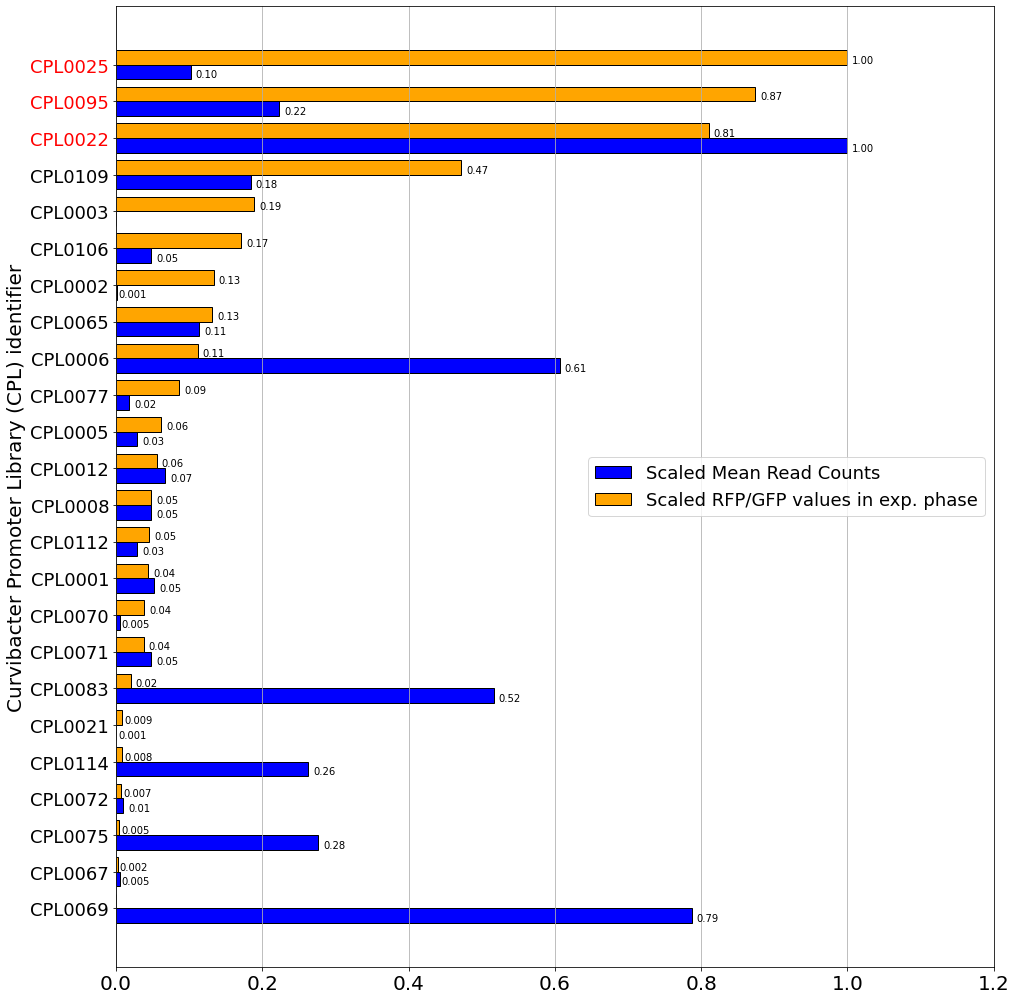

In [182]:
savep = "../results/normalizedCounts_vs_exp_phase.png"

sorted_exp_phase = []
sorted_read_counts = []
sorted_cont = []
sorted_non_norm_exp_phase = []
sorted_non_norm_read_counts = []


for exp, counts, cont, non_norm_exp, non_norm_counts in sorted(zip(exp_phase_norm,read_counts_norm,strain_id, exp_phase, read_counts)):
    sorted_read_counts.append(counts)
    sorted_exp_phase.append(exp)
    sorted_cont.append(cont)
    sorted_non_norm_exp_phase.append(non_norm_exp)
    sorted_non_norm_read_counts.append(non_norm_counts)
    
plot_norm_vs_flur_bar_plot(sorted_cont, sorted_read_counts, sorted_exp_phase, savep, xlim=1.2, legend_position="center right", fsize=20, fsize_text=10, fig_size=(14,14))

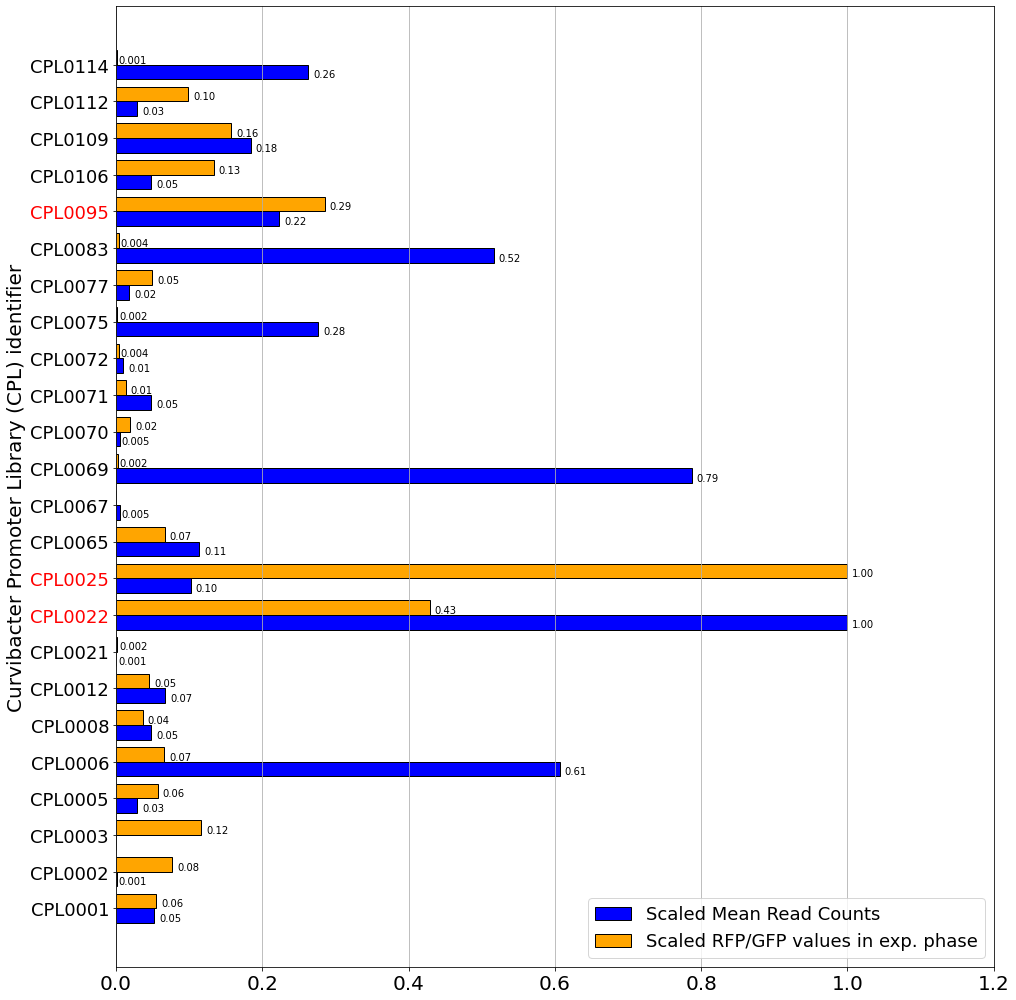

In [183]:
savep = "../results/normalizedCounts_vs_stat_phase.png"
plot_norm_vs_flur_bar_plot(strain_id, read_counts_norm, stat_phase_norm, savep, xlim=1.2, legend_position="lower right", fsize=20, fsize_text=10, fig_size=(14,14))

In [184]:
# none normalized (0-1) lists of exponential phase RFU values (RFP/GFP) and nroamlized read count data
exp_phase_log = []
read_counts_log = []
cpls = []

for exp, count, cpl in sorted(zip(exp_phase, read_counts,strain_id)):
    
    if exp != 0.0 and count != 0.0:
        
        exp_phase_log.append(np.log(exp))
        read_counts_log.append(np.log(count))
        cpls.append(cpl)
    else:
        if exp == 0.0:
            exp = 0.0000001
        if count == 0.0:
            count = 0.0000001
            
        exp_phase_log.append(np.log(exp))
        read_counts_log.append(np.log(count))
        cpls.append(cpl)  

savep = "../results/exp_phase_log_vs_read_counts_log.png"

[-6.841971538436134, -1.1421761268178126] [4.31748811353631, 10.324300937591092]


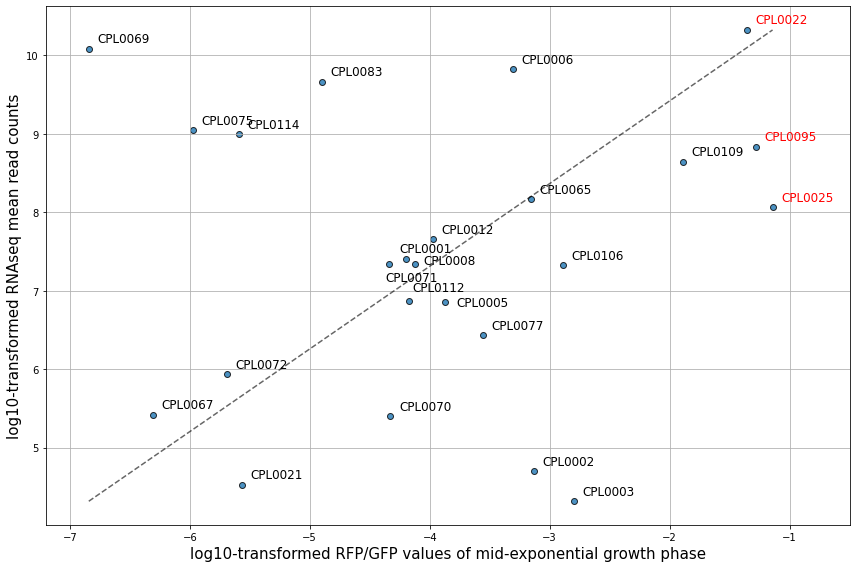

In [246]:
msize = np.interp(sorted_non_norm_exp_phase,  [min(sorted_non_norm_exp_phase), max(sorted_non_norm_exp_phase)], [100,1000])

colormap = plt.get_cmap('viridis')  # You can choose a different colormap

# Normalize the data to map it to colormap range
norm = plt.Normalize(min(sorted_non_norm_read_counts), max(sorted_non_norm_read_counts))

#hex_colors = [colormap(norm(value)) for value in sorted_non_norm_read_counts]
#hex_colors = [plt.cm.colors.rgb2hex(color) for color in hex_colors]

plt.figure(figsize=(12,8))
#exp_phase_log, poly1d_fn(exp_phase_log), '--k', 
#plt.scatter(exp_phase_log,read_counts_log, 
#         s=msize,c=hex_colors, edgecolor="black", alpha=0.8)

plt.scatter(exp_phase_log,read_counts_log, edgecolor="black", alpha=0.8)
x1, y1 = [min(exp_phase_log), max(exp_phase_log)], [min(read_counts_log), max(read_counts_log)]
print(x1,y1)
plt.plot(x1, y1,'--k', alpha=0.6) #label="f(x,y) = x,y"

plt.xlabel("log10-transformed RFP/GFP values of mid-exponential growth phase", fontsize=15)
plt.ylabel("log10-transformed RNAseq mean read counts", fontsize=15)
#locs, labels = plt.xticks()
plt.grid()

for x,y,text in zip(exp_phase_log, read_counts_log, cpls):
    if text == "CPL0001":
        plt.text(x-0.05, y+.08, text, fontsize=12)
    elif text == "CPL0008":
        plt.text(x+0.07, y, text, fontsize=12)
    elif text == "CPL0005":
        plt.text(x+0.1, y-0.05, text, fontsize=12)

    elif text == "CPL0071":
        plt.text(x-.03, y-.22, text, fontsize=12)
    elif text == "CPL0112":
        plt.text(x+.03, y+.12, text, fontsize=12)
    elif text == "CPL0095" or text == "CPL0022" or text == "CPL0025":
        plt.text(x+.07, y+.08, text, fontsize=12, color="red")
    else:
        plt.text(x+.07, y+.08, text, fontsize=12)
#plt.xticks(exp_phase_log,cpls, rotation=95)



#colorbar = plt.colorbar(plt.cm.ScalarMappable(cmap=colormap, norm=norm))
#colorbar.set_label("mean read counts", fontsize=15) 


plt.xlim(-7.2,-0.5)
plt.tight_layout()
#plt.legend(loc="lower right", fontsize=15)



plt.savefig(savep, dpi=400)

# calculate GC content

In [181]:
old_to_new_locus_tag

{'AEP_00001': 'AEP_RS00005',
 'AEP_00002': 'AEP_RS00010',
 'AEP_00003': 'AEP_RS00015',
 'AEP_00004': 'AEP_RS00020',
 'AEP_00005': 'AEP_RS00025',
 'AEP_00006': 'AEP_RS00030',
 'AEP_00007': 'AEP_RS00035',
 'AEP_00008': 'AEP_RS00040',
 'AEP_00009': 'AEP_RS00045',
 'AEP_00010': 'AEP_RS00050',
 'AEP_00011': 'AEP_RS00055',
 'AEP_00012': 'AEP_RS00060',
 'AEP_00013': 'AEP_RS00065',
 'AEP_00014': 'AEP_RS00070',
 'AEP_00015': 'AEP_RS00075',
 'AEP_00016': 'AEP_RS00080',
 'AEP_00017': 'AEP_RS00085',
 'AEP_00018': 'AEP_RS00090',
 'AEP_00019': 'AEP_RS00095',
 'AEP_00020': 'AEP_RS00100',
 'AEP_00021': 'AEP_RS00105',
 'AEP_00022': 'AEP_RS00110',
 'AEP_00023': 'AEP_RS00115',
 'AEP_00024': 'AEP_RS00120',
 'AEP_00025': 'AEP_RS00125',
 'AEP_00026': 'AEP_RS00130',
 'AEP_00027': 'AEP_RS00135',
 'AEP_00028': 'AEP_RS00140',
 'AEP_00029': 'AEP_RS00145',
 'AEP_00030': 'AEP_RS00150',
 'AEP_00031': 'AEP_RS00155',
 'AEP_00032': 'AEP_RS00160',
 'AEP_00033': 'AEP_RS00165',
 'AEP_00034': 'AEP_RS00170',
 'AEP_00035': 

In [193]:
highlight_sequences = {}
with open("../results/target_promoter_sequences.faa","r") as targetfile:
    for line in targetfile.readlines():
        if line.startswith(">"):
            aep = line.rstrip().split(">")[1]
            if aep in old_to_new_locus_tag.keys():
                aep = old_to_new_locus_tag[aep]
            highlight_sequences[aep] = ""
        else:
            highlight_sequences[aep] += line.rstrip()

In [194]:
for promoter in highlight_sequences.keys():
    gc_content = (highlight_sequences[promoter].count("G") + highlight_sequences[promoter].count("C")) / len(highlight_sequences[promoter])
    print(promoter, gc_content, len(highlight_sequences[promoter]))

AEP_RS01090 0.38235294117647056 68
AEP_RS01250 0.4794520547945205 73
AEP_RS01580 0.5 108
AEP_RS20820 0.5166666666666667 60
AEP_RS04395 0.4931506849315068 146
AEP_RS05045 0.45528455284552843 123
AEP_RS05585 0.3770491803278688 61
AEP_RS05725 0.5454545454545454 66
AEP_RS05845 0.4854368932038835 103
AEP_RS06545 0.5967741935483871 62
AEP_RS07810 0.5443037974683544 79
AEP_RS07815 0.5252525252525253 99
AEP_RS07885 0.5833333333333334 72
AEP_RS08710 0.5348837209302325 86
AEP_RS09225 0.48333333333333334 60
AEP_RS09965 0.46808510638297873 94
AEP_RS10515 0.5263157894736842 95
AEP_RS10655 0.46774193548387094 62
AEP_RS11090 0.31666666666666665 60
AEP_RS11205 0.40789473684210525 76
AEP_RS11420 0.415929203539823 113
AEP_RS12015 0.5666666666666667 60
AEP_RS12495 0.4772727272727273 88
AEP_RS13215 0.44086021505376344 93
AEP_RS13605 0.4430379746835443 79
AEP_RS14265 0.5714285714285714 84
AEP_RS14715 0.5188679245283019 106
AEP_RS14850 0.625 96
AEP_RS15400 0.5 86
AEP_RS17635 0.4215686274509804 102
AEP_RS195

# identified motifs

In [184]:
sites = pd.read_csv("../results/xstreme/sites.tsv", delimiter="\t")

In [185]:
sites.head()

,motif_ID,motif_ALT_ID,seq_ID,site_Start,site_End,site_Strand,site_Score,site_Sequence
0,1-CGCGASCAGY,STREME-1,AEP_01563,66,75,-,16.28,CGCGACCAGT
1,1-CGCGASCAGY,STREME-1,AEP_03530,8,17,-,13.95,CGCGAGCAGC
2,1-CGCGASCAGY,STREME-1,AEP_00244,34,43,+,13.95,CGCGAGCAGC
3,1-CGCGASCAGY,STREME-1,AEP_02507,38,47,-,13.95,CGCGAGCAGC
4,1-CGCGASCAGY,STREME-1,AEP_03085,41,50,+,13.07,CGCGAGTAGC


In [189]:
sites['new_AEP'] = sites.seq_ID.apply(lambda x: old_to_new_locus_tag[x] if x in old_to_new_locus_tag.keys() else x)

In [190]:
import docx

In [191]:
sites.head()

,motif_ID,motif_ALT_ID,seq_ID,site_Start,site_End,site_Strand,site_Score,site_Sequence,new_AEP
0,1-CGCGASCAGY,STREME-1,AEP_01563,66,75,-,16.28,CGCGACCAGT,AEP_RS07815
1,1-CGCGASCAGY,STREME-1,AEP_03530,8,17,-,13.95,CGCGAGCAGC,AEP_RS17635
2,1-CGCGASCAGY,STREME-1,AEP_00244,34,43,+,13.95,CGCGAGCAGC,AEP_RS01250
3,1-CGCGASCAGY,STREME-1,AEP_02507,38,47,-,13.95,CGCGAGCAGC,AEP_RS12495
4,1-CGCGASCAGY,STREME-1,AEP_03085,41,50,+,13.07,CGCGAGTAGC,AEP_RS15400


In [205]:
aep_to_cpl = pd.read_csv("../data/cpls_to_aep.csv")

In [206]:
aep_to_cpl_dict

{}

In [207]:
aep_to_cpl_dict = {}
for strain, aep in zip(aep_to_cpl['strain ID'],aep_to_cpl['AEP nr']):
    aep_to_cpl_dict[aep] = strain

In [213]:
aep_to_cpl_dict["AEP_RS12495"] = "CPL0073"

In [231]:
aep_to_cpl_dict

{'AEP_RS09965': 'CPL0001',
 'AEP_RS14945': 'CPL0002',
 'AEP_RS06545': 'CPL0003',
 'AEP_RS13605': 'CPL0004',
 'AEP_RS10655': 'CPL0005',
 'AEP_RS04395': 'CPL0006',
 'AEP_RS19530': 'CPL0008',
 'AEP_RS05845': 'CPL0012',
 'J23100 control': 'CPL0017',
 'AEP_RS08710': 'CPL0021',
 'AEP_RS05045': 'CPL0022',
 'AEP_RS11205': 'CPL0025',
 'AEP_RS15400': 'CPL0055',
 'AEP_RS13215': 'CPL0065',
 'AEP_RS07810': 'CPL0066',
 'AEP_RS20820': 'CPL0067',
 'AEP_RS07885': 'CPL0068',
 'AEP_RS14715': 'CPL0069',
 'AEP_RS10515': 'CPL0070',
 'AEP_RS12015': 'CPL0071',
 'AEP_RS05725': 'CPL0072',
 'AEP_02507': 'CPL0073',
 'AEP_RS01250': 'CPL0074',
 'AEP_RS11090': 'CPL0075',
 'AEP_RS14265': 'CPL0077',
 'AEP_RS01580': 'CPL0079',
 'AEP_RS14850': 'CPL0080',
 'AEP_RS02305': 'CPL0081',
 'AEP_RS07815': 'CPL0083',
 'AEP_RS11420': 'CPL0095',
 'AEP_RS17635': 'CPL0106',
 'AEP_RS01090': 'CPL0109',
 'AEP_RS09225': 'CPL0112',
 'AEP_RS05585': 'CPL0114',
 'AEP_RS12495': 'CPL0073'}

In [214]:
sites['CPL'] = sites.new_AEP.apply(lambda x: aep_to_cpl_dict[x] if x in aep_to_cpl_dict.keys() else x)

In [219]:
sMotifs = {}
sMotifs["1"] = "AmrZ,LasR: P. aeruginosa; BldD: S. coelicolor"
sMotifs["2"] = "CodY: B. anthracis"
sMotifs["3"] = "LexA: V.parahaemolyticus"
sMotifs["4"] = "ExpR: S. meliloti; DosR: M.tuberculosis"
sMotifs["5"] = "CodY: S.pyogenes; CodY: L.lactis; CcpA: S.pneumoniae"

In [220]:
excel_savep = "../results/tf_binding_site_motifs.xlsx"

In [225]:
for cpl in all_cpls.keys():
    if cpl not in list(sites[['CPL','motif_ID','site_Start','site_End','site_Sequence']].CPL):
        print(cpl)

CPL0017
CPL0114


In [226]:
sites[['CPL','motif_ID','site_Start','site_End','site_Sequence']].head()

,CPL,motif_ID,site_Start,site_End,site_Sequence
0,CPL0083,1-CGCGASCAGY,66,75,CGCGACCAGT
1,CPL0106,1-CGCGASCAGY,8,17,CGCGAGCAGC
2,CPL0074,1-CGCGASCAGY,34,43,CGCGAGCAGC
3,CPL0073,1-CGCGASCAGY,38,47,CGCGAGCAGC
4,CPL0055,1-CGCGASCAGY,41,50,CGCGAGTAGC


In [230]:
sites_t = sites[['CPL','motif_ID','site_Start','site_End','site_Sequence']].copy()
sites_t['similarMotifs'] = sites_t.motif_ID.apply(lambda x: sMotifs[x.split("-")[0]])
sites_t.sort_values(by="CPL",inplace=True)
sites_t.to_excel(excel_savep)